### Python调用Ensemble Learning算法——sklearn
参考[sklearn doc]（https://scikit-learn.org/stable/modules/ensemble.html）

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

#### Boosting

先以`AdaBoost`算法为例，此处基学习器为决策树桩(`decision stumps`)。

后介绍`Gradient Boosted Regression Trees (GBRT)`。

##### AdaBoost

In [13]:
iris = load_iris()
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, iris.data, iris.target, cv=5)
scores.mean()                             

0.9466666666666665

此处可以继续调优的参数有基学习器的数量`n_estimators`， 基学习器的复杂度等。

##### GBRT——Classification

In [15]:
X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.913

##### GBRT——Regression

In [19]:
X, y = make_friedman1(n_samples=1200, random_state=0, noise=1.0)
X_train, X_test = X[:200], X[200:]
y_train, y_test = y[:200], y[200:]
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
    max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
mean_squared_error(y_test, est.predict(X_test))    

5.009154859960321

#### Bagging

以KNN算法为例，先演示仅调用KNN算法的流程，之后演示如何进行Bagging

##### Naive KNN

In [3]:
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y) 

print(neigh.predict([[1.1]]))
print(neigh.predict_proba([[0.9]]))

[0]
[[0.66666667 0.33333333]]


##### Bagging KNN

In [11]:
bagging = BaggingClassifier(KNeighborsClassifier(n_neighbors=3),
                            max_samples=0.9, max_features=1
                            )
bagging.fit(X, y) 

print(bagging.predict([[1.1]]))
print(bagging.predict_proba([[0.9]]))

[0]
[[0.6 0.4]]


此处`max_samples`限制抽取样本子集的数量（占比），`max_features`限制抽取特征的数量（占比）。此外还有`bootstrap`设置样本抽取是否是有放回，`bootstrap_features`设置特征抽取是否是有放回。

#### Stacking

参考[StackingClassifier of mlxtend](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/#properties).

主要是包含两个接口，其一是[`StackingClassifier`](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/#properties), 是比较原始的`Stacking`, 两外一个是[`StackingCVClassifier`](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/)， 其在第一层运用了cross-validation来避免过拟合。根据文档所说，我们应该尽可能地选择第二种方法：
>Please note that this type of Stacking is prone to overfitting due to information leakage. The related `StackingCVClassifier` does not derive the predictions for the 2nd-level classifier from the same datast that was used for training the level-1 classifiers and is recommended instead.

##### StackingClassifier

In [22]:
from sklearn import datasets
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
import numpy as np
import warnings

warnings.simplefilter('ignore')

In [23]:
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

In [24]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.93 (+/- 0.05) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.95 (+/- 0.03) [StackingClassifier]


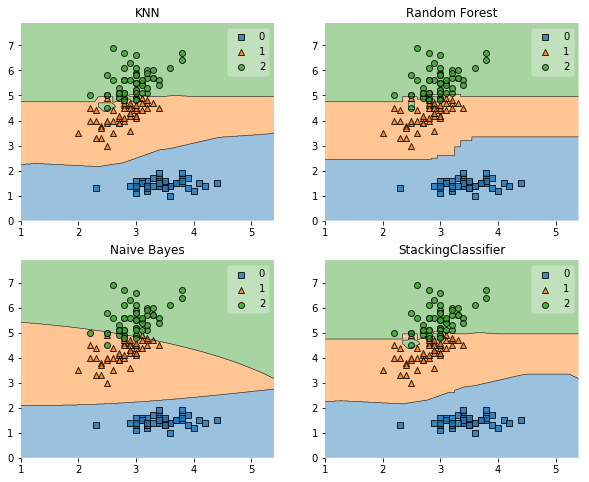

In [27]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['KNN', 
                          'Random Forest', 
                          'Naive Bayes',
                          'StackingClassifier'],
                          itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()

##### StackingCVClassifier

In [28]:
from mlxtend.classifier import StackingCVClassifier

RANDOM_SEED = 42

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

In [29]:
# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr,
                            random_state=RANDOM_SEED)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.90 (+/- 0.03) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.91 (+/- 0.01) [StackingClassifier]


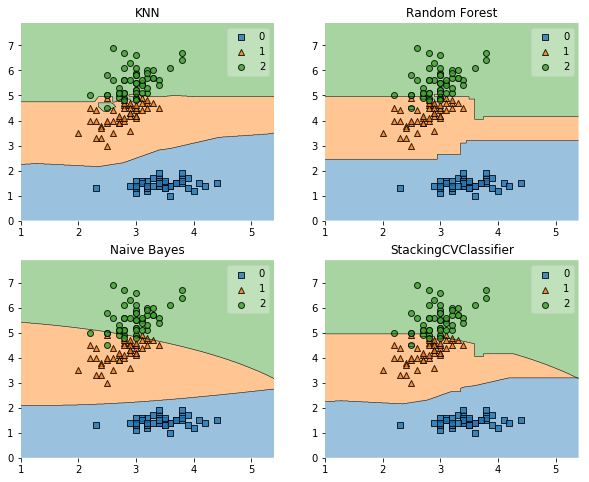

In [30]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['KNN', 
                          'Random Forest', 
                          'Naive Bayes',
                          'StackingCVClassifier'],
                          itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()